In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy import units as u
from scipy.interpolate import interp1d

from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, 53)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

plt.rcParams['font.size'] = 18

path = '/Users/arcticfox/Documents/atmospheres/v1298tau'

In [7]:
WAVELENGTHS = np.load(os.path.join(path, 'interp_1d_wavelength.npy'), allow_pickle=True)
ORDERS = np.load(os.path.join(path,'interp_1d_orders.npy'), allow_pickle=True)
SPECTRA = np.load(os.path.join(path,'interp_1d_spectra.npy'), allow_pickle=True)
TIMES = Time(np.load(os.path.join(path,'mjddates.npy'), allow_pickle=True), format='mjd').jd

In [3]:
BOTH = np.where(TIMES<=2458870.762)[0]
TRANSIT_C = np.where( (TIMES>2458870.762) & (TIMES<=2458870.941))[0]
OUT = np.where( TIMES>2458870.941)[0]

In [4]:
TRANSIT_C

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45])

In [5]:
# DOPPLER FORMULA
def doppler(wave, centered_wave):
    delta_wave = (centered_wave - wave) 
    c = 3e8 * u.m / u.s
    return -((delta_wave / centered_wave) * c).to(u.km/u.s)

### Finds what order a feature is in

In [6]:
def find_order(region):
    global WAVELENGTHS

    for i in range(len(WAVELENGTHS[10])):
        inds = np.where((WAVELENGTHS[10][i] >= region[0]+1) & 
                         (WAVELENGTHS[10][i] <= region[-1]-1))[0]
        if len(inds) > 0:
            return i

### Fits 2nd order to feature to find centered wavelength

In [7]:
def fit_minimum(wave, flux):
    for i in range(len(flux)):
        plt.plot(wave, flux[i], 'k')

    plt.plot(wave, np.nanmedian(flux, axis=0), 'r')
    x = np.arange(wave[-1], wave[0], 0.001)
    
    fit = np.polyfit(wave, np.nanmedian(flux, axis=0), deg=2)
    model = np.poly1d(fit)
    
    model_fit = model(x)

    plt.plot(x, model_fit, 'y')
    plt.plot(x[np.argmin(model_fit)], model_fit[np.argmin(model_fit)], 'y*', ms=15)
    plt.title(x[np.argmin(model_fit)])
    plt.show()
    
    return x[np.argmin(model_fit)]

### Creates a 2D array based on the spectra for a given order

In [8]:
SPECTRA.shape

(53, 582945)

In [9]:
def create_2d(inds, region):
    global SPECTRA
    
    summed_last = SPECTRA[-4]
    
    in_n_out = np.zeros((len(inds), len(region)))
    
    for i in range(len(inds)):
        j = inds[i]
        in_n_out[i] = SPECTRA[j][region] / summed_last[region] - 1
    
    return in_n_out

### Plots 2D arrays as a function of flux difference with out of transit

In [10]:
def plot_2d_velocity(arr, region, line, vmin, vmax, delta):
    global WAVELENGTHS
    
    plt.figure(figsize=(12,5))
    for i in range(len(arr)):
        plt.scatter(doppler(WAVELENGTHS[i][region], delta) - 
                    doppler(line, delta),
                    np.ones(WAVELENGTHS[i][region].shape)-i,
                    c=arr[i] * 100, vmax=vmax,
                    vmin=vmin)
    plt.title('Velocity Space')
    plt.xlabel('V - V$_{Halpha}$ [km s$^{-1}$]')
    plt.ylabel('Time')
    plt.show()
    
##########################################
    
def plot_2d_wave(arr, region, line, vmin, vmax):
    global WAVELENGTHS, SPECTRA
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,10), sharex=True)

    for i in range(len(arr)):
        if i != 1:
            ax1.plot(WAVELENGTHS[0][region] - line,
                     SPECTRA[i][region] - 1)
        ax2.scatter(WAVELENGTHS[i][region] - line,
                    np.ones(WAVELENGTHS[i][region].shape)-i,
                    c=arr[i] * 100, vmax=vmax, vmin=vmin)

    ax1.plot(WAVELENGTHS[0][region] - line,
             np.nanmedian(SPECTRA[:,region] - 1, axis=0),
             lw=3, c='k')
    ax1.set_title('Wavelength Space')
    ax1.set_ylabel('Relative Flux - 1')  
    ax1.set_ylim(-0.3, 0)
    plt.xlabel('$\lambda - \lambda_{Halpha}$ [nm]')
    plt.ylabel('Time')
    plt.show()

## Analysis for H-alpha

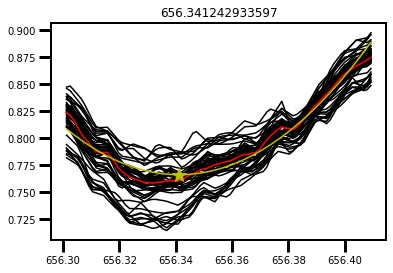

656.341242933597

In [11]:
HALPHA_RANGE = [656.3, 656.41]
FIT_RANGE = np.where((WAVELENGTHS[10] >= HALPHA_RANGE[0]) & 
                     (WAVELENGTHS[10] <= HALPHA_RANGE[1]) & 
                     (ORDERS[10] == 34))[0]
FIT_RANGE = np.flip(FIT_RANGE)
HALPHA_LINE = fit_minimum(WAVELENGTHS[10, FIT_RANGE], 
                          SPECTRA[:,FIT_RANGE])
HALPHA_LINE

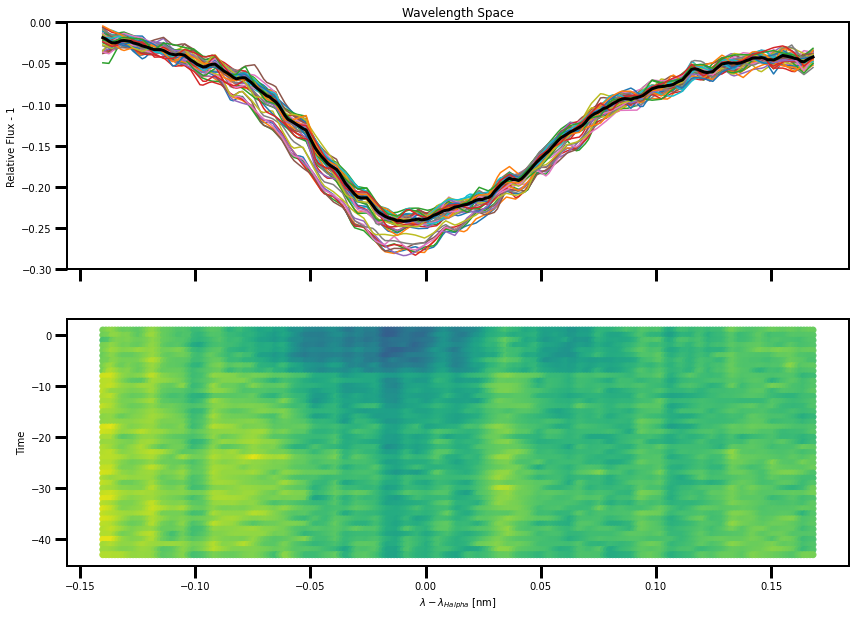

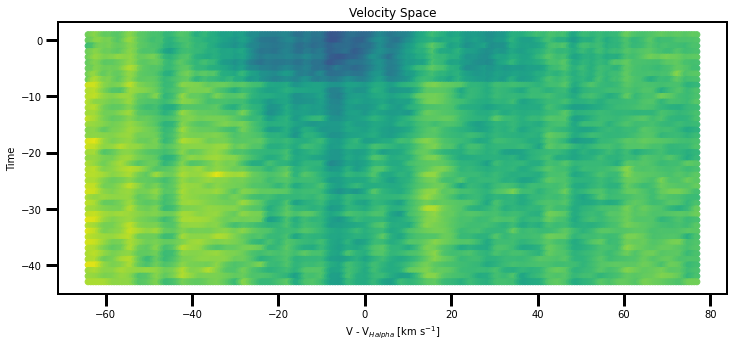

In [12]:
DELTA_WAVE_HA = 656.3

FIT_RANGE = np.where((WAVELENGTHS[10] >= HALPHA_RANGE[0]-0.1) & 
                     (WAVELENGTHS[10] <= HALPHA_RANGE[1]+0.1) &
                     (ORDERS[10] == 34))[0]

#bad = np.array([], dtype=int)
COMBINED = np.sort(np.append(BOTH, TRANSIT_C))
COMBINED = np.delete(COMBINED, 1)

IN_V_OUT = create_2d(COMBINED, FIT_RANGE)

plot_2d_wave(IN_V_OUT, FIT_RANGE, HALPHA_LINE, -15, 4)
plot_2d_velocity(IN_V_OUT, FIT_RANGE, HALPHA_LINE, -14, 4, DELTA_WAVE_HA)

## Detectable RV features:
- measure the RV from each night 
    - take a template
    - x-corr between template and each spectrum
    - measure RV: peak in velocity space)
    - SERVAL code
- doppler tomography (shapes of line)
    - Collier-Cameron (2010) 

In [13]:
from scipy.signal import correlate, correlate2d
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook

In [14]:
def xcorrelate(wavelength, spectra, orders, order, 
               line, delta_line, template_inds, plot=True):
    
    q = (ORDERS[20] == order)

    cutends = 1200
    template = np.nanmedian(spectra[np.arange(0,len(spectra),1,dtype=int)][:,q], axis=0)
    template = template[cutends:-cutends]
    #tw = np.nanmedian(wavelength[template_inds][:,q], axis=0)
    
    cross_corr = np.zeros((spectra.shape[0], len(wavelength[0][q][cutends:-cutends])))
    peaks = np.array([], dtype=np.float64)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    
    for i in tqdm_notebook(range(len(spectra))):
        wave = wavelength[i][q][cutends:-cutends]
        velocity = doppler(wave, delta_line) -  doppler(line, delta_line)
        
        flux = spectra[i][q][cutends:-cutends]
        
        ax1.plot(wave, flux, c=colors[i])
        corr = np.correlate(template - np.nanmedian(template), 
                            flux - np.nanmedian(flux), 
                            mode='same')
        cross_corr[i] = corr
        c = np.arange(np.argmax(corr)-10, np.argmax(corr)+10,1,dtype=int)
        ax2.plot(wave[c], corr[c], c=colors[i])
        fit = fit_maximum(wave[c], corr[c])
        maximum = -fit[1]/(2*fit[0]) # pixel units
        peaks = np.append(peaks, maximum)
        
    if plot:
        plt.show()
    else:
        plt.close()
           
    return peaks, cross_corr

- get everything in velocity space
- make fake data and step each spectrum by 10 m/s (flat in log wavelength, so add a factor)
    - Make sure everthing moves linearly
    - Calculate pixel $\rightarrow$ RV space
- interpret the fit of the cross-correlation (WHAT UNITS?!)

## Injected fake RVs

In [15]:
def inject_rv(wave, rv):
    c = 3e8 * u.m / u.s
    rv = rv * u.m / u.s
    factor = rv/c
    delta_wave = factor*wave
    return wave - delta_wave

## Telluric Analysis

In [16]:
import h5py
f = h5py.File('telluric_model_r.hdf', 'r')

- ID an order that's primarily tellurics, take a fairly narrow region, x-correlate on those
    - should be able to serve as a wavelength calibration
    - using a wavelength reference from observation to observation
        - how much are references off 
    - subtract off RVs from the tellurics (across a bunch of regions)
        - use to change wavelength grid
        - Ben thinks they'll move by ~ 50 m/s
- Look at the spectra right around the jump
    - do they look shifted relative to each other in a way that's different from the one right before and the one right after? 
    - take difference between the 2 and if there is a velocity shift, you'll see it in a dipole-y shape
    - see if the difference is different between the stellar lines and the tellurics. if the tellurics subtract off well and the star does not, the star has MOOOOVEDDD
- P A N I C -- bring in Dr. Andreas, masteroftellurics

In [17]:
f['wavelength_solution']['fiber_2'].keys()

<KeysViewHDF5 ['67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94']>

<IPython.core.display.Javascript object>


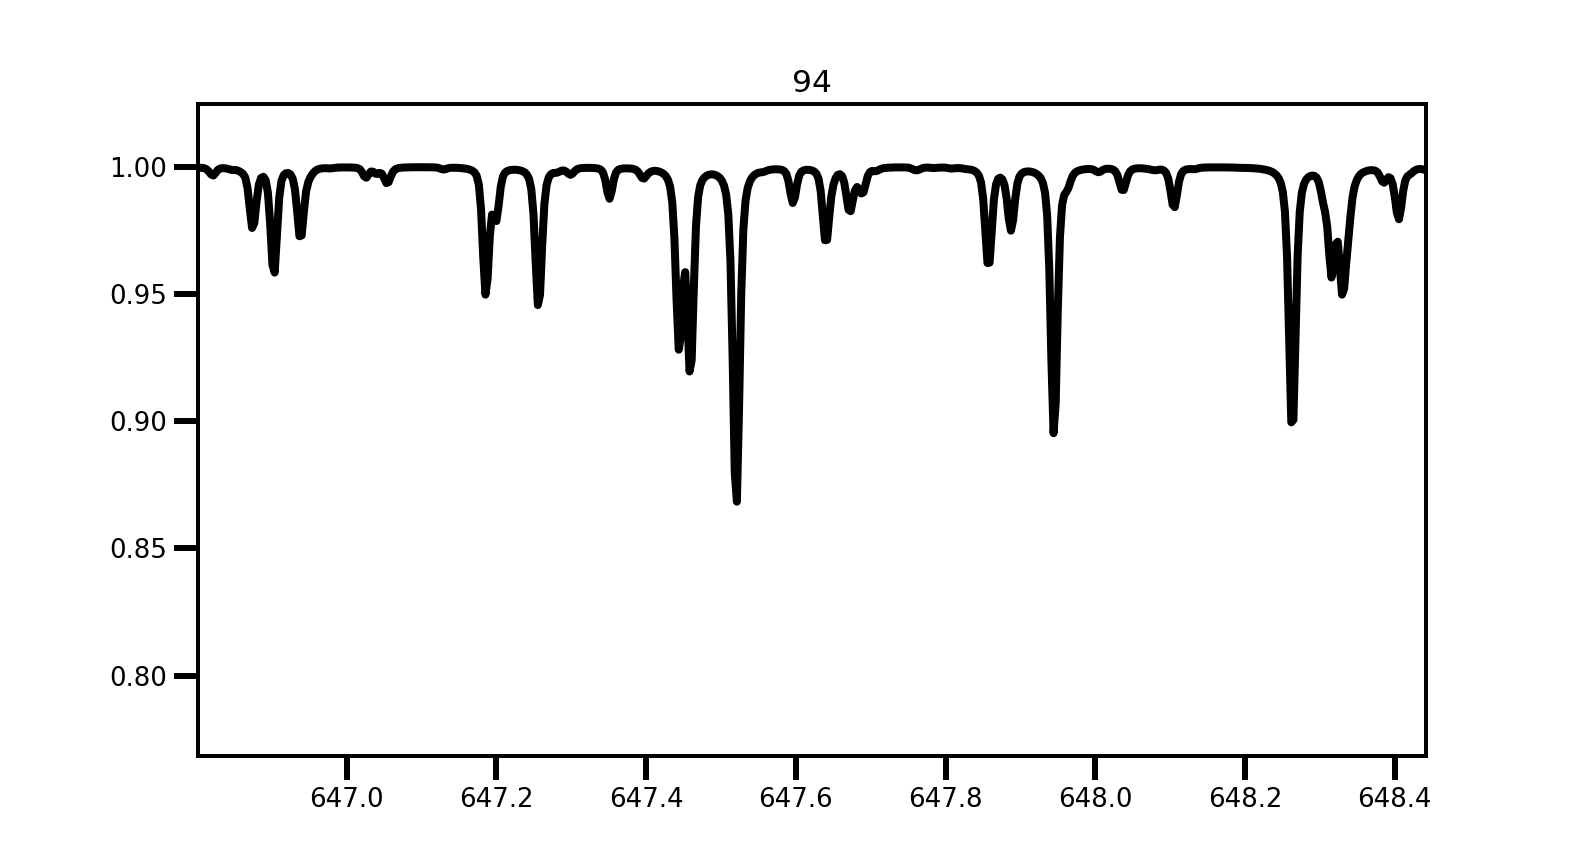

array([34., 35.])

In [39]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

plt.rcParams['font.size']=13
plt.rcParams['figure.figsize']=(11,6)

for key in f['wavelength_solution']['fiber_2'].keys():
    telluric_wave = f['wavelength_solution']['fiber_2'][key][()]
    telluric_spec = f['telluric_model']['fiber_2'][key][()]
    if key == '94':
        same = np.where((WAVELENGTHS[0] >= telluric_wave[0]) &
                        (WAVELENGTHS[0] <= telluric_wave[-1])) ##)[0]
                        #(ORDERS[0] == 32))[0]
        plt.plot(WAVELENGTHS[0][same], SPECTRA[0][same], 'w', linewidth=1)
        plt.title(key)
        plt.plot(telluric_wave-0.24, telluric_spec, 'k', linewidth=4)
            #plt.xlim(906.83,906.9)
plt.show()
np.unique(ORDERS[0][same])

In [40]:
telluric_orders = [32, 32, 
                   31, 31,
                   27, 27, 27,
                   25, 25, 
                   29, 29, 
                   31, 31, 
                   32, 32,
                   30, 30]
telluric_lines = [[717.286, 717.396],
                  [716.731, 716.781],
                  [728.675, 728.717],
                  [728.737, 728.799],
                  [830.318, 830.507],
                  [827.133, 827.187],
                  [832.053, 832.152],
                  [897.026, 897.151],
                  [909.876, 910.037],
                  [770.217, 770.254],
                  [768.86, 768.898],
                  [723.922, 723.959],
                  [731.493, 731.528],
                  [717.324, 717.347],
                  [717.356, 717.393],
                  [764.206, 764.251],
                  [765.140, 765.171]
                 ]

In [41]:
template = SPECTRA[42]#np.nanmedian(SPECTRA[np.arange(0,len(SPECTRA),1,dtype=int)], axis=0)
temp_wave = WAVELENGTHS[42]

In [42]:
def fit_maximum(x, y):
    fit = np.polyfit(x, y, deg=2)
    return fit

32 [717.286, 717.396]


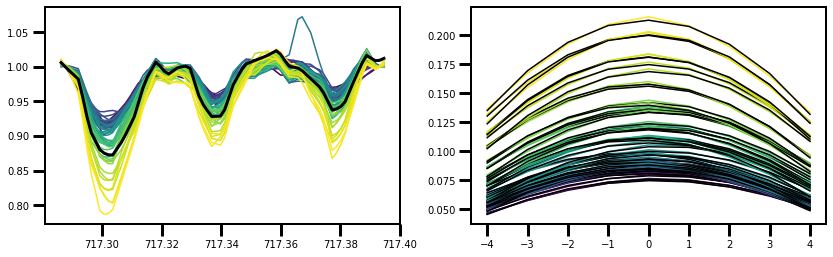

32 [716.731, 716.781]


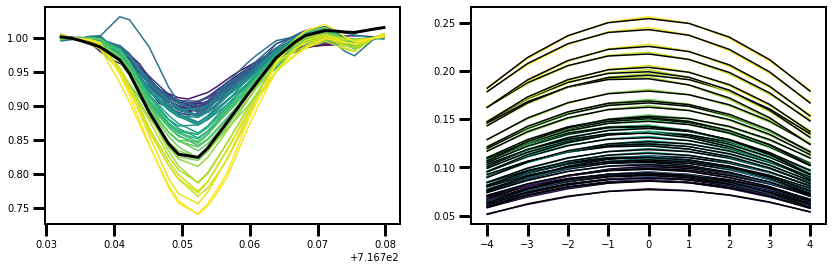

31 [728.675, 728.717]


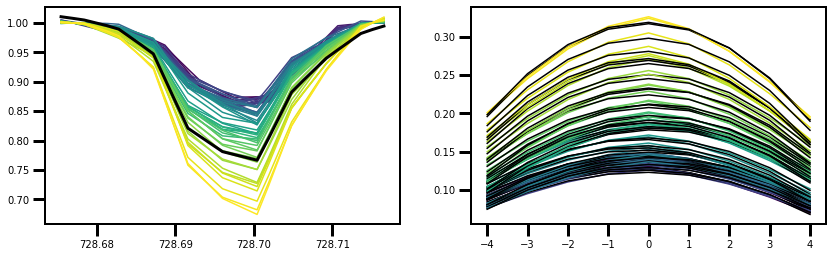

31 [728.737, 728.799]


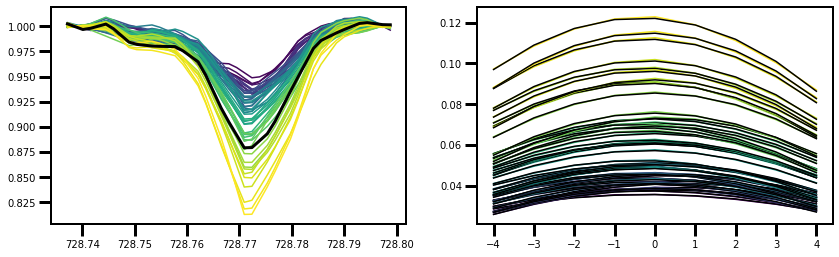

27 [830.318, 830.507]


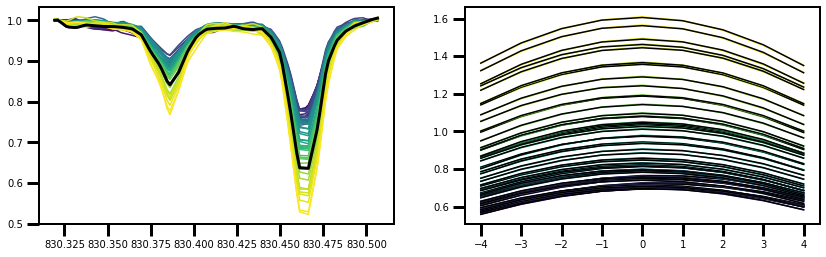

27 [827.133, 827.187]


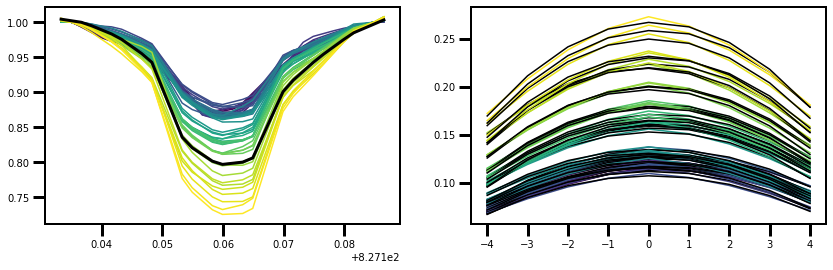

27 [832.053, 832.152]


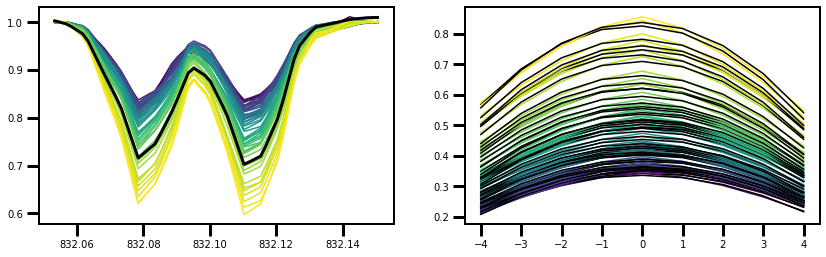

25 [897.026, 897.151]


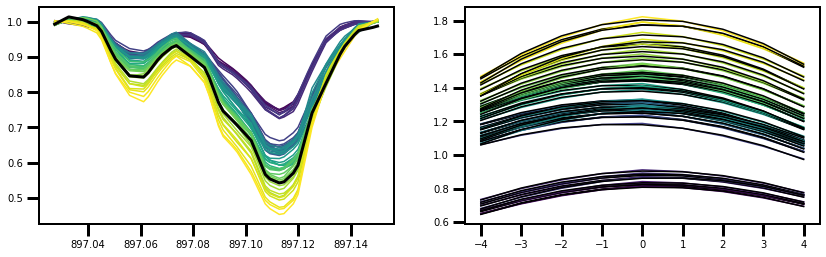

25 [909.876, 910.037]


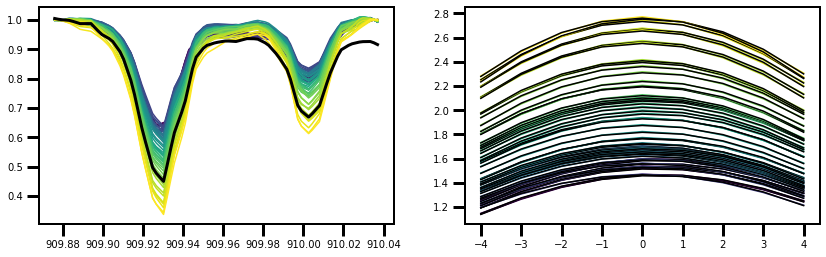

29 [770.217, 770.254]


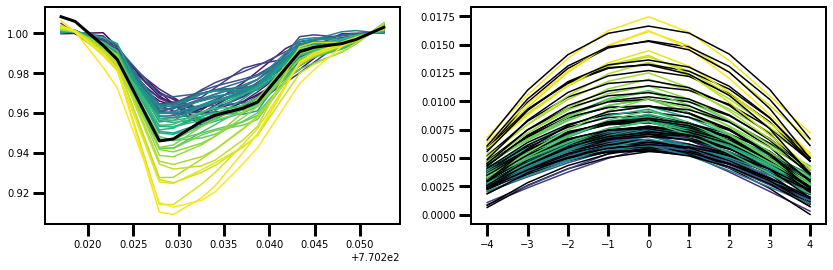

29 [768.86, 768.898]


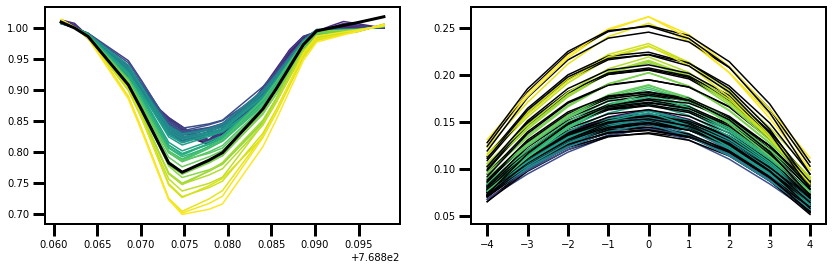

31 [723.922, 723.959]


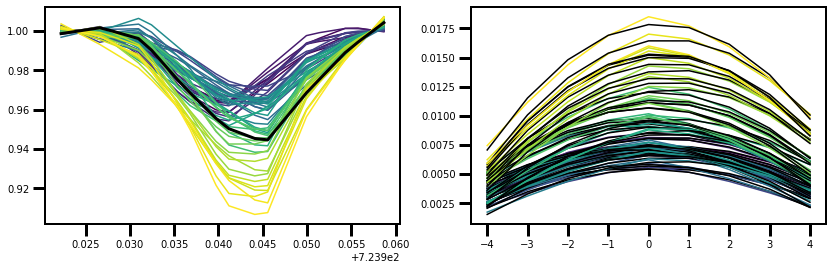

31 [731.493, 731.528]


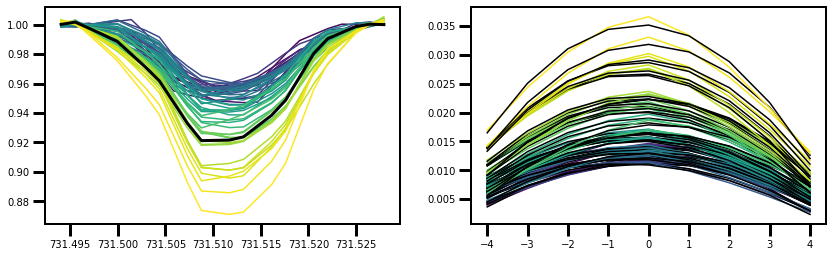

32 [717.324, 717.347]


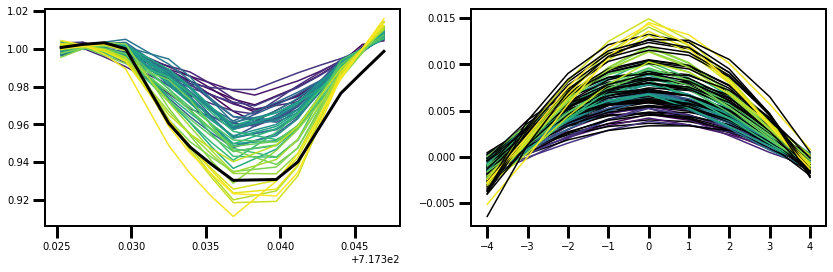

32 [717.356, 717.393]


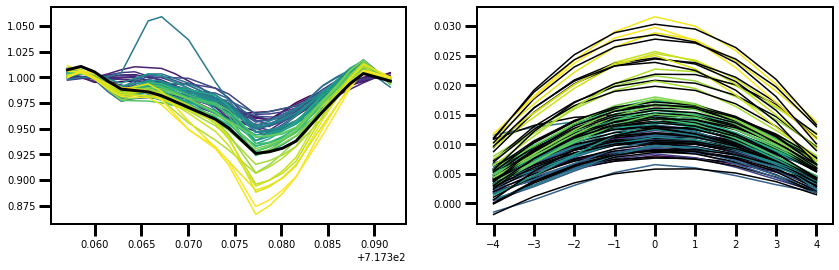

30 [764.206, 764.251]


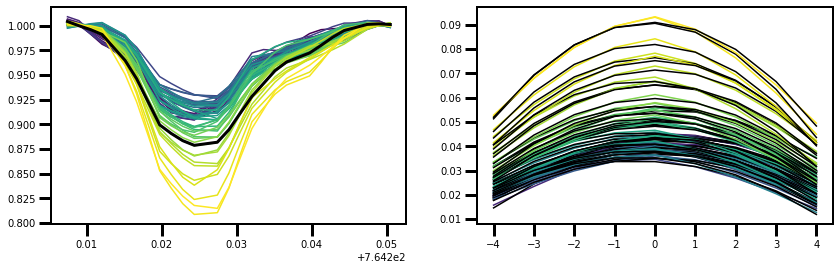

30 [765.14, 765.171]


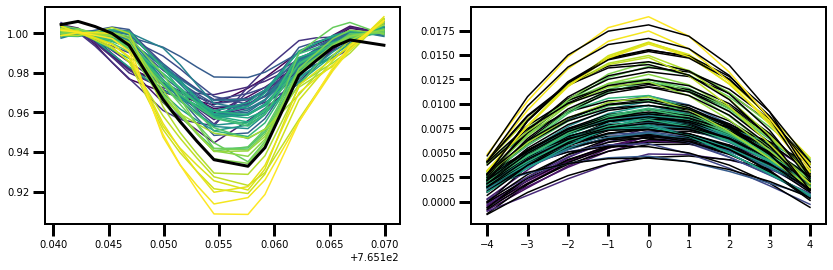

In [43]:
%matplotlib inline
telluric_rvs = np.zeros((len(telluric_orders),len(SPECTRA)))

for tl in tqdm_notebook(range(len(telluric_orders))):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    peaks = np.zeros(len(SPECTRA))
    print(telluric_orders[tl], telluric_lines[tl])
    for i in range(len(SPECTRA)):
    #    print(telluric_orders[tl], telluric_lines[tl][0], telluric_lines[tl][1])
        q =  ((ORDERS[i] == telluric_orders[tl]) & 
             (WAVELENGTHS[i] >= telluric_lines[tl][0]) &
             (WAVELENGTHS[i] <= telluric_lines[tl][1]))
        
        outofline = np.append(np.arange(0,5,1,dtype=int),
                              np.arange(len(SPECTRA[i][q])-2, len(SPECTRA[i][q]), 1, dtype=int))
        temp = template[q]
        interp = np.polyfit(np.append(temp_wave[0:3],temp_wave[-3:]), 
                            np.append(temp[0:3], temp[-3:]), deg=1)
        model = np.poly1d(interp)
        temp /= model(temp_wave[q])
        temp /= np.nanmedian(temp[outofline])
        
        
        wave = WAVELENGTHS[i][q]
        flux = SPECTRA[i][q]
        interp = np.polyfit(np.append(wave[0:3],wave[-3:]), 
                            np.append(flux[0:3], flux[-3:]), deg=1)
        model = np.poly1d(interp)
        flux /= model(wave)
        flux /= np.nanmedian(flux[outofline])

       # flux -= np.nanmedian([flux[0]-1, flux[-1]-1])/2.0   

        ax1.plot(wave, flux, c=colors[i])
        corr = np.correlate(temp - np.nanmedian(temp), 
                            flux - np.nanmedian(flux), 
                            mode='same')
        
        c = np.arange(np.argmax(corr)-4, np.argmax(corr)+5,1,dtype=int)
        #print(np.argmax(corr), len(corr))

        ax2.plot(c-np.argmax(corr), corr[c], c=colors[i])
        fit = fit_maximum(c-np.argmax(corr), corr[c])
        
        ax2.plot(c-np.argmax(corr), np.poly1d(fit)(c-np.argmax(corr)), 'k')
        maximum = -fit[1]/(2*fit[0]) # pixel units
        peaks[i] = maximum

    ax1.plot(temp_wave[q], temp, 'k', linewidth=3)
    plt.show()
    telluric_rvs[tl] = np.nanmedian(np.diff(np.log(wave))) * 3e8 * peaks

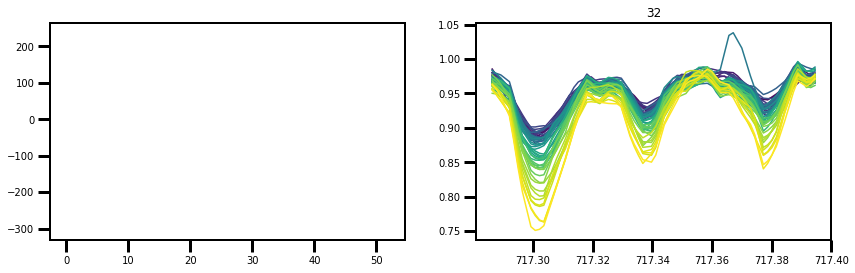

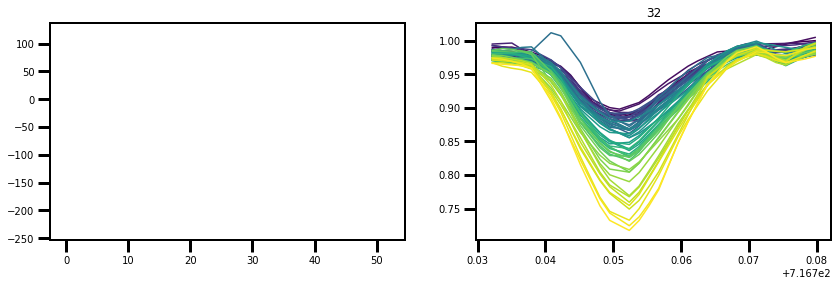

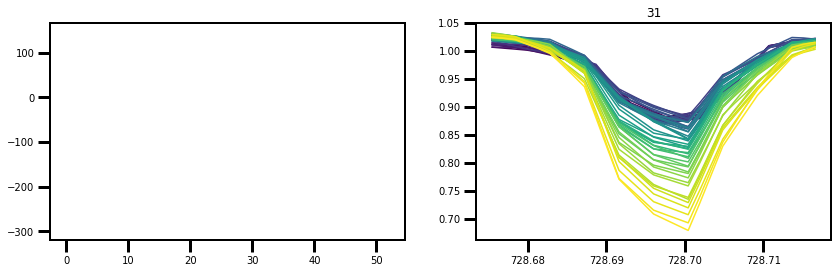

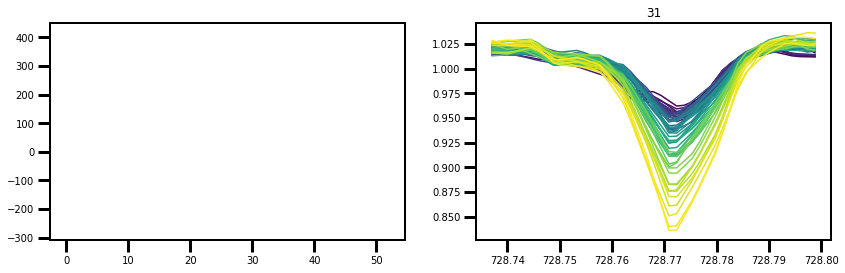

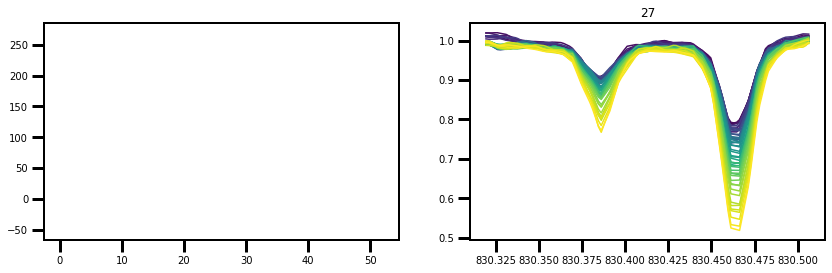

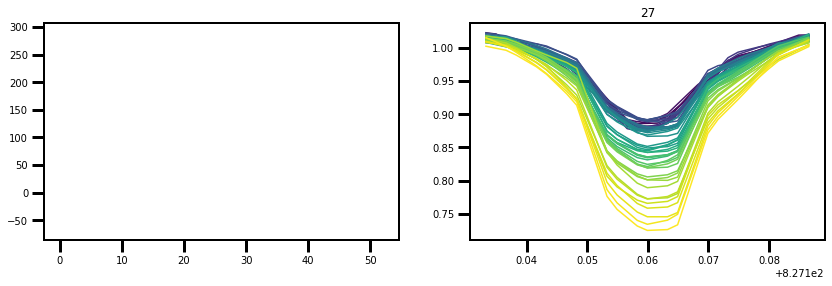

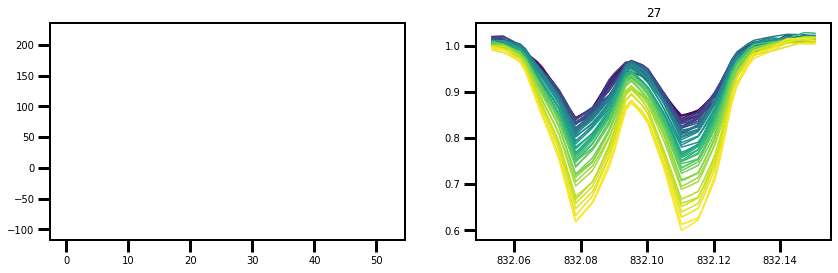

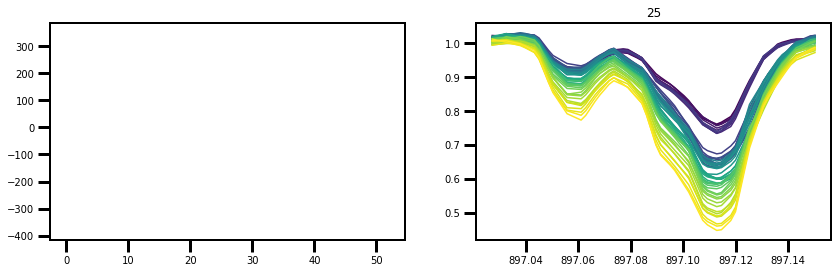

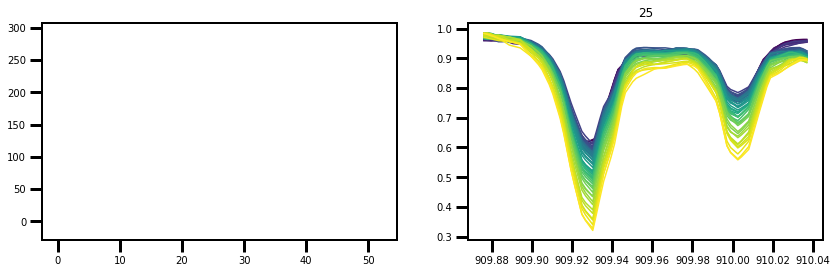

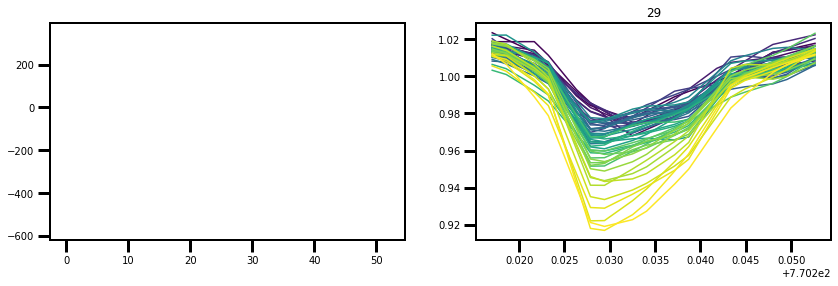

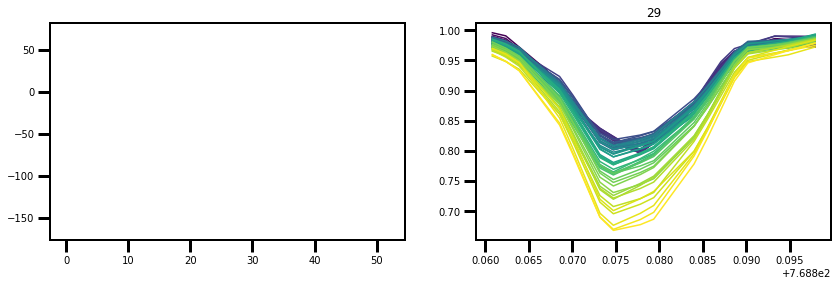

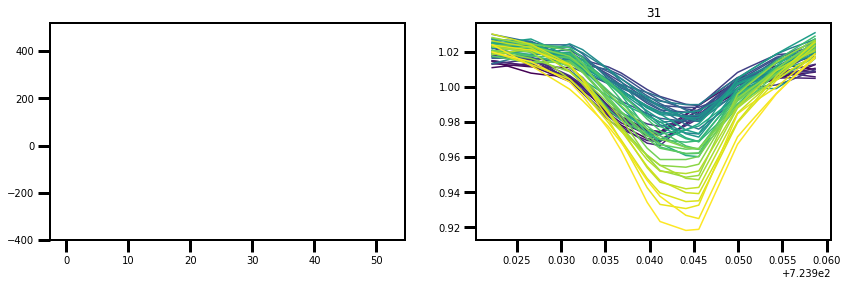

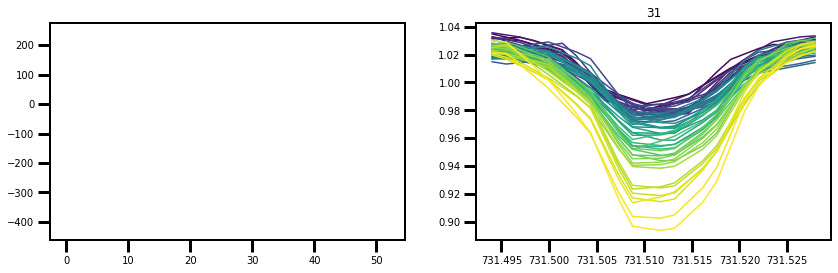

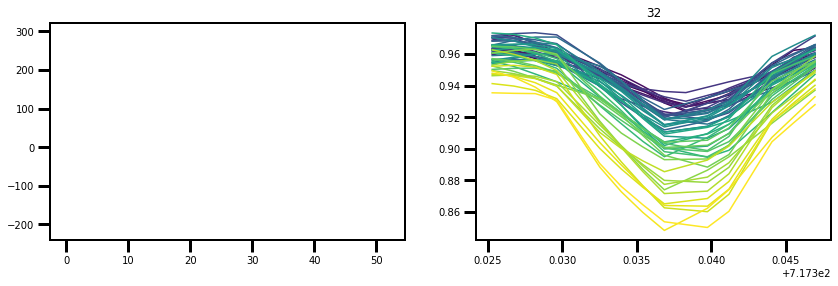

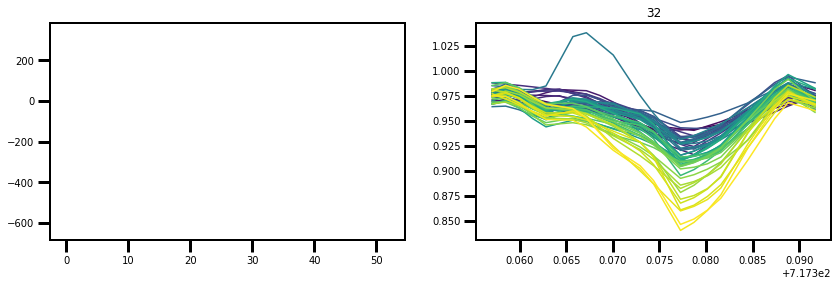

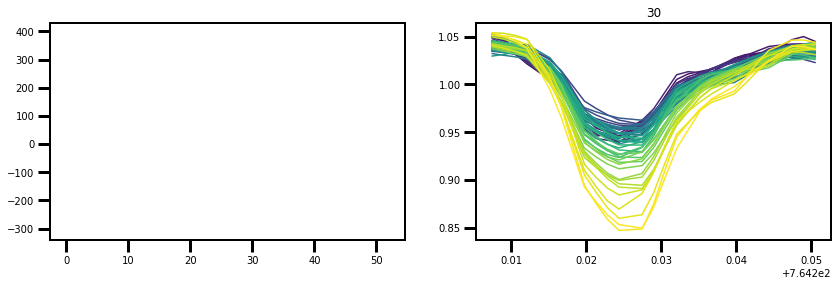

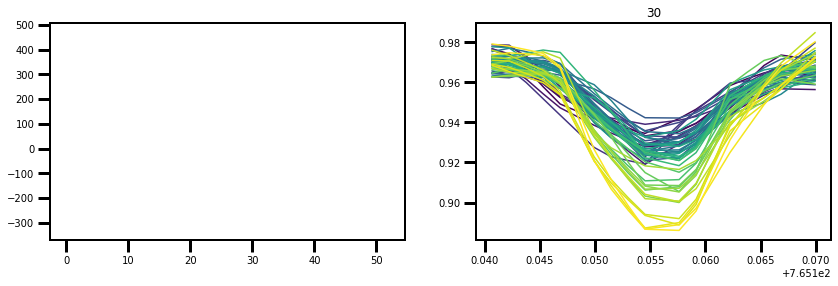

In [44]:
rv_diffs = np.zeros(len(SPECTRA))
for i in range(len(telluric_rvs)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    ax1.plot(telluric_rvs[i], 'w.')
    for j in range(len(SPECTRA)):
        q =  ((ORDERS[j] == telluric_orders[i]) & 
             (WAVELENGTHS[j] >= telluric_lines[i][0]) &
             (WAVELENGTHS[j] <= telluric_lines[i][1]))
        temp = template[q]

        wave = WAVELENGTHS[j][q]
        # normalize to one, not saturated lines, 
        # make sure going to the same value on either side of the line
        flux = SPECTRA[j][q]#/np.nanmedian(SPECTRA[j][q])

        ax2.plot(wave, flux, c=colors[j])
    ax2.set_title(telluric_orders[i])
    plt.show()

In [ ]:
rv_diffs = np.zeros(len(SPECTRA))
for i in range(len(SPECTRA)):
    plt.plot(i, np.nanmean(telluric_rvs[:,i]), 'w.')
   # try:
   #     rv_diffs[i] = np.nanmean(telluric_rvs[:,i+1])-np.nanmean(telluric_rvs[:,i])
   # except IndexError:
   #     rv_diffs[i] = np.nanmean(telluric_rvs[:,i])-np.nanmean(telluric_rvs[:,i-1])

In [ ]:
def inject_rv(wave, rv, remove=False):
    c = 3e8
    log_delta_wave = np.log(rv) - np.log(c) + np.log(wave) # delta log lambda
    delta_wave = rv/c * wave
    
    if remove == False:
        return wave + delta_wave
    else:
        new_wave = wave - delta_wave
        #d = np.nanmean(np.log(wave[ORDERS[0]==22]) - 
        #               np.log(new_wave[ORDERS[0]==22]))
        #new_rv = np.log(d)-np.log(wave[ORDERS[0]==22])+np.log(c)
        #print(rv, np.exp(new_rv[0]))
        return new_wave

In [ ]:
NEW_WAVELENGTHS = np.copy(WAVELENGTHS)
for i in range(len(WAVELENGTHS)):
    if i < np.argmax(rv_diffs):
        diff = rv_diffs[i] + np.nanmax(rv_diffs)
    else:
        diff = rv_diffs[i]
    NEW_WAVELENGTHS[i] = inject_rv(WAVELENGTHS[i], diff, remove=True)

In [ ]:
for i in range(len(WAVELENGTHS)):
    d = np.nanmean(np.log10(WAVELENGTHS[i][ORDERS[0]==22]) - 
                       np.log10(NEW_WAVELENGTHS[i][ORDERS[0]==22]))
    #print(i, d)
    new_rv = np.log10(d)-np.log10(WAVELENGTHS[i][ORDERS[0]==22])+np.log10(3e8)
    print(i, rv_diffs[i], 10**np.nanmedian(rv))

## Injected fake RVs

In [ ]:
fake_waves = np.zeros((len(SPECTRA), len(NEW_WAVELENGTHS[0])))
fake_spect = np.zeros((len(SPECTRA), len(NEW_WAVELENGTHS[0])))
fake_rvs = np.linspace(1,len(SPECTRA)*10,len(SPECTRA))
for i, rv in enumerate(fake_rvs):
    fake_waves[i] = inject_rv(NEW_WAVELENGTHS[i], rv)
    fake_spect[i] = SPECTRA[i]

fit_peaks, _ = xcorrelate(fake_waves, fake_spect, ORDERS, 34, HALPHA_LINE, 
                          DELTA_WAVE_HA, OUT,
                          plot=True)
fit = np.polyfit(fit_peaks, fake_rvs, deg=1)
calibration_line = np.poly1d(fit)
plt.plot(fit_peaks, fake_rvs, 'wo')
plt.plot(fit_peaks, calibration_line(fit_peaks), 'ro')
plt.show()

In [ ]:
d = np.abs(np.nanmean(np.log10(WAVELENGTHS[10][ORDERS[0]==22]) - 
                   np.log10(fake_waves[10][ORDERS[0]==22]))) 
rv = 10**(np.log10(d)-np.log10(WAVELENGTHS[0][ORDERS[0]==22])+np.log10(3e8))
print(np.nanmedian(rv), fake_rvs[10])

## Get RVs

In [ ]:
plt.rcParams['font.size'] = 18

unique_orders = np.unique(ORDERS[0])

rvs = np.zeros((len(unique_orders), len(SPECTRA)))

for o, order in enumerate(unique_orders[0:2]):
    fit_peaks, _ = xcorrelate(fake_waves, fake_spect, ORDERS, order, 
                              HALPHA_LINE, DELTA_WAVE_HA, OUT, plot=False)
    fit = np.polyfit(fit_peaks, fake_rvs, deg=1)
    line = np.poly1d(fit)

    peaks, _ = xcorrelate(NEW_WAVELENGTHS, SPECTRA, ORDERS, order, 
                          HALPHA_LINE, DELTA_WAVE_HA, OUT)
    
    plt.plot(calibration_line(peaks), 'ko')
    plt.xlabel('Observation')
    plt.ylabel('RV [m/s]')
    plt.show()
    
    rvs[o] = calibration_line(peaks)
#plt.savefig('/Users/arcticfox/Desktop/rv.png', dpi=200, rasterize=True,
#           bbox_inches='tight')
#plt.plot(peaks, line(peaks), 'k')

In [ ]:
for i in range(len(SPECTRA)):
    plt.errorbar(i, np.nanmean(rvs[:,i]),
                 #yerr=np.nanstd(rvs[:,i])/np.sqrt(len(SPECTRA)),
                 marker='o')
plt.xlabel('Observation')
plt.ylabel('Mean RV [m/s]')

In [ ]:
def inject_rv(wave, rv):
    c = 3e8 * u.m / u.s
    rv = rv * u.m / u.s
    factor = rv/c
    delta_wave = factor*wave
    return wave - delta_wave

In [ ]:
fake_waves = np.zeros((len(SPECTRA), len(NEW_WAVELENGTHS[0])))
fake_spect = np.zeros((len(SPECTRA), len(NEW_WAVELENGTHS[0])))
fake_rvs = np.arange(0,len(SPECTRA)*10,10)
for i, rv in enumerate(fake_rvs):
    fake_waves[i] = inject_rv(NEW_WAVELENGTHS[i], rv)
    fake_spect[i] = SPECTRA[i]

In [ ]:
NEW_WAVELENGTHS = np.copy(WAVELENGTHS)
for i in range(len(WAVELENGTHS)):
    if i < np.argmax(rv_diffs):
        diff = rv_diffs[i] + np.nanmax(rv_diffs)
    else:
        diff = rv_diffs[i]
    NEW_WAVELENGTHS[i] = WAVELENGTHS[i] - WAVELENGTHS[i]*(diff/3e8)

In [ ]:
q = ORDERS[0]==35
plt.plot(WAVELENGTHS[0][q], SPECTRA[0][q],'r')
plt.plot(NEW_WAVELENGTHS[0][q], SPECTRA[0][q],'k')
plt.xlim(656.1,656.5)